# df103_NanoAODHiggsAnalysis
An example of complex analysis with RDataFrame: reconstructing the Higgs boson.

This tutorial is a simplified but yet complex example of an analysis reconstructing the Higgs boson decaying to two Z
bosons from events with four leptons. The data and simulated events are taken from CERN OpenData representing a
subset of the data recorded in 2012 with the CMS detector at the LHC. The tutorials follows the Higgs to four leptons
analysis published on CERN Open Data portal ([10.7483/OPENDATA.CMS.JKB8.RR42](http://opendata.cern.ch/record/5500)).
The resulting plots show the invariant mass of the selected four lepton systems in different decay modes (four muons,
four electrons and two of each kind) and in a combined plot indicating the decay of the Higgs boson with a mass of
about 125 GeV.

The following steps are performed for each sample with data and simulated events in order to reconstruct the Higgs
boson from the selected muons and electrons:
1. Select interesting events with multiple cuts on event properties, e.g., number of leptons, kinematics of the
   leptons and quality of the tracks.
2. Reconstruct two Z bosons of which only one on the mass shell from the selected events and apply additional cuts on
   the reconstructed objects.
3. Reconstruct the Higgs boson from the remaining Z boson candidates and calculate its invariant mass.

Another aim of this version of the tutorial is to show a way to blend C++ and Python code. All the functions that
make computations on data to define new columns or filter existing ones in a precise way, better suited to be written
in C++, have been moved to a header that is then declared to the ROOT C++ interpreter. The functions that instead
create nodes of the computational graph (e.g. Filter, Define) remain inside the main Python script.

The tutorial has the fast mode enabled by default, which reads the data from already skimmed
datasets with a total size of only 51MB. If the fast mode is disabled, the tutorial runs over
the full dataset with a size of 12GB.




**Author:**  Stefan Wunsch (KIT, CERN), Vincenzo Eduardo Padulano (UniMiB, CERN)  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, April 17, 2024 at 11:08 AM.</small></i>

In [1]:
import ROOT
import os

Enable multi-threading

In [2]:
ROOT.ROOT.EnableImplicitMT()

Include necessary header

In [3]:
higgs_header_path = os.path.join(os.sep, str(ROOT.gROOT.GetTutorialDir()) + os.sep, "dataframe" + os.sep,
                                 "df103_NanoAODHiggsAnalysis_python.h")

ROOT.gInterpreter.Declare('#include "{}"'.format(higgs_header_path))

True

Python functions

In [4]:
def reco_higgs_to_2el2mu(df):
    """Reconstruct Higgs from two electrons and two muons"""
    # Filter interesting events
    df_base = selection_2el2mu(df)
    # Compute masses of Z systems
    df_z_mass = df_base.Define("Z_mass", "compute_z_masses_2el2mu(Electron_pt, Electron_eta, Electron_phi,"
                               " Electron_mass, Muon_pt, Muon_eta, Muon_phi, Muon_mass)")
    # Cut on mass of Z candidates
    df_z_cut = filter_z_candidates(df_z_mass)
    # Reconstruct H mass
    df_h_mass = df_z_cut.Define("H_mass", "compute_higgs_mass_2el2mu(Electron_pt, Electron_eta, Electron_phi,"
                                " Electron_mass, Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

    return df_h_mass


def selection_2el2mu(df):
    """Select interesting events with two electrons and two muons"""
    df_ge2el2mu = df.Filter("nElectron>=2 && nMuon>=2", "At least two electrons and two muons")
    df_eta = df_ge2el2mu.Filter("All(abs(Electron_eta)<2.5) && All(abs(Muon_eta)<2.4)", "Eta cuts")

    df_pt = df_eta.Filter("pt_cuts(Muon_pt, Electron_pt)", "Pt cuts")

    df_dr = df_pt.Filter("dr_cuts(Muon_eta, Muon_phi, Electron_eta, Electron_phi)", "Dr cuts")

    df_iso = df_dr.Filter("All(abs(Electron_pfRelIso03_all)<0.40) && All(abs(Muon_pfRelIso04_all)<0.40)",
                          "Require good isolation")
    df_el_ip3d = df_iso.Define("Electron_ip3d_el", "sqrt(Electron_dxy*Electron_dxy + Electron_dz*Electron_dz)")
    df_el_sip3d = df_el_ip3d.Define("Electron_sip3d_el",
                                    "Electron_ip3d_el/sqrt(Electron_dxyErr*Electron_dxyErr + "
                                    "Electron_dzErr*Electron_dzErr)")
    df_el_track = df_el_sip3d.Filter("All(Electron_sip3d_el<4) && All(abs(Electron_dxy)<0.5) &&"
                                     " All(abs(Electron_dz)<1.0)",
                                     "Electron track close to primary vertex with small uncertainty")
    df_mu_ip3d = df_el_track.Define("Muon_ip3d_mu", "sqrt(Muon_dxy*Muon_dxy + Muon_dz*Muon_dz)")

    df_mu_sip3d = df_mu_ip3d.Define("Muon_sip3d_mu",
                                    "Muon_ip3d_mu/sqrt(Muon_dxyErr*Muon_dxyErr + Muon_dzErr*Muon_dzErr)")
    df_mu_track = df_mu_sip3d.Filter("All(Muon_sip3d_mu<4) && All(abs(Muon_dxy)<0.5) && All(abs(Muon_dz)<1.0)",
                                     "Muon track close to primary vertex with small uncertainty")
    df_2p2n = df_mu_track.Filter("Sum(Electron_charge)==0 && Sum(Muon_charge)==0",
                                 "Two opposite charged electron and muon pairs")

    return df_2p2n


def reco_higgs_to_4mu(df):
    """Reconstruct Higgs from four muons"""
    # Filter interesting events
    df_base = selection_4mu(df)

    # Reconstruct Z systems
    df_z_idx = df_base.Define("Z_idx", "reco_zz_to_4l(Muon_pt, Muon_eta, Muon_phi, Muon_mass, Muon_charge)")

    # Cut on distance between muons building Z systems
    df_z_dr = df_z_idx.Filter("filter_z_dr(Z_idx, Muon_eta, Muon_phi)", "Delta R separation of muons building Z system")

    # Compute masses of Z systems
    df_z_mass = df_z_dr.Define("Z_mass", "compute_z_masses_4l(Z_idx, Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

    # Cut on mass of Z candidates
    df_z_cut = filter_z_candidates(df_z_mass)

    # Reconstruct H mass
    df_h_mass = df_z_cut.Define("H_mass", "compute_higgs_mass_4l(Z_idx, Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

    return df_h_mass


def selection_4mu(df):
    """Select interesting events with four muons"""
    df_ge4m = df.Filter("nMuon>=4", "At least four muons")

    df_iso = df_ge4m.Filter("All(abs(Muon_pfRelIso04_all)<0.40)", "Require good isolation")
    df_kin = df_iso.Filter("All(Muon_pt>5) && All(abs(Muon_eta)<2.4)", "Good muon kinematics")
    df_ip3d = df_kin.Define("Muon_ip3d", "sqrt(Muon_dxy*Muon_dxy + Muon_dz*Muon_dz)")
    df_sip3d = df_ip3d.Define("Muon_sip3d", "Muon_ip3d/sqrt(Muon_dxyErr*Muon_dxyErr + Muon_dzErr*Muon_dzErr)")
    df_pv = df_sip3d.Filter("All(Muon_sip3d<4) && All(abs(Muon_dxy)<0.5) && All(abs(Muon_dz)<1.0)",
                            "Track close to primary vertex with small uncertainty")
    df_2p2n = df_pv.Filter("nMuon==4 && Sum(Muon_charge==1)==2 && Sum(Muon_charge==-1)==2",
                           "Two positive and two negative muons")

    return df_2p2n


def filter_z_candidates(df):
    """Apply selection on reconstructed Z candidates"""
    df_z1_cut = df.Filter("Z_mass[0] > 40 && Z_mass[0] < 120", "Mass of first Z candidate in [40, 120]")
    df_z2_cut = df_z1_cut.Filter("Z_mass[1] > 12 && Z_mass[1] < 120", "Mass of second Z candidate in [12, 120]")

    return df_z2_cut


def reco_higgs_to_4el(df):
    """Reconstruct Higgs from four electrons"""
    # Filter interesting events
    df_base = selection_4el(df)

    # Reconstruct Z systems
    df_z_idx = df_base.Define("Z_idx",
                              "reco_zz_to_4l(Electron_pt, Electron_eta, Electron_phi, Electron_mass, Electron_charge)")

    # Cut on distance between Electrons building Z systems
    df_z_dr = df_z_idx.Filter("filter_z_dr(Z_idx, Electron_eta, Electron_phi)",
                              "Delta R separation of Electrons building Z system")

    # Compute masses of Z systems
    df_z_mass = df_z_dr.Define("Z_mass",
                               "compute_z_masses_4l(Z_idx, Electron_pt, Electron_eta, Electron_phi, Electron_mass)")

    # Cut on mass of Z candidates
    df_z_cut = filter_z_candidates(df_z_mass)

    # Reconstruct H mass
    df_h_mass = df_z_cut.Define("H_mass",
                                "compute_higgs_mass_4l(Z_idx, Electron_pt, Electron_eta, Electron_phi, Electron_mass)")

    return df_h_mass


def selection_4el(df):
    """Select interesting events with four electrons"""
    df_ge4el = df.Filter("nElectron>=4", "At least our electrons")
    df_iso = df_ge4el.Filter("All(abs(Electron_pfRelIso03_all)<0.40)", "Require good isolation")
    df_kin = df_iso.Filter("All(Electron_pt>7) && All(abs(Electron_eta)<2.5)", "Good Electron kinematics")
    df_ip3d = df_kin.Define("Electron_ip3d", "sqrt(Electron_dxy*Electron_dxy + Electron_dz*Electron_dz)")
    df_sip3d = df_ip3d.Define("Electron_sip3d",
                              "Electron_ip3d/sqrt(Electron_dxyErr*Electron_dxyErr + Electron_dzErr*Electron_dzErr)")
    df_pv = df_sip3d.Filter("All(Electron_sip3d<4) && All(abs(Electron_dxy)<0.5) && All(abs(Electron_dz)<1.0)",
                            "Track close to primary vertex with small uncertainty")
    df_2p2n = df_pv.Filter("nElectron==4 && Sum(Electron_charge==1)==2 && Sum(Electron_charge==-1)==2",
                           "Two positive and two negative electrons")

    return df_2p2n


def plot(sig, bkg, data, x_label, filename):
    """
    Plot invariant mass for signal and background processes from simulated
    events overlay the measured data.
    """
    # Canvas and general style options
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    d = ROOT.TCanvas("", "", 800, 700)
    # Make sure the canvas stays in the list of canvases after the macro execution
    ROOT.SetOwnership(d, False)
    d.SetLeftMargin(0.15)

    # Get signal and background histograms and stack them to show Higgs signal
    # on top of the background process
    h_bkg = bkg
    h_cmb = sig.Clone()

    h_cmb.Add(h_bkg)
    h_cmb.SetTitle("")
    h_cmb.GetXaxis().SetTitle(x_label)
    h_cmb.GetXaxis().SetTitleSize(0.04)
    h_cmb.GetYaxis().SetTitle("N_{Events}")
    h_cmb.GetYaxis().SetTitleSize(0.04)
    h_cmb.SetLineColor(ROOT.kRed)
    h_cmb.SetLineWidth(2)
    h_cmb.SetMaximum(18)
    h_bkg.SetLineWidth(2)
    h_bkg.SetFillStyle(1001)
    h_bkg.SetLineColor(ROOT.kBlack)
    h_bkg.SetFillColor(ROOT.kAzure - 9)

    # Get histogram of data points
    h_data = data
    h_data.SetLineWidth(1)
    h_data.SetMarkerStyle(20)
    h_data.SetMarkerSize(1.0)
    h_data.SetMarkerColor(ROOT.kBlack)
    h_data.SetLineColor(ROOT.kBlack)

    # Draw histograms
    h_cmb.DrawCopy("HIST")
    h_bkg.DrawCopy("HIST SAME")
    h_data.DrawCopy("PE1 SAME")

    # Add legend
    legend = ROOT.TLegend(0.62, 0.70, 0.82, 0.88)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h_data, "Data", "PE1")
    legend.AddEntry(h_bkg, "ZZ", "f")
    legend.AddEntry(h_cmb, "m_{H} = 125 GeV", "f")
    legend.Draw()

    # Add header
    cms_label = ROOT.TLatex()
    cms_label.SetTextSize(0.04)
    cms_label.DrawLatexNDC(0.16, 0.92, "#bf{CMS Open Data}")
    header = ROOT.TLatex()
    header.SetTextSize(0.03)
    header.DrawLatexNDC(0.63, 0.92, "#sqrt{s} = 8 TeV, L_{int} = 11.6 fb^{-1}")

    # Save plot
    d.SaveAs(filename)

In fast mode, take samples from */cms_opendata_2012_nanoaod_skimmed/*, which has
the preselections from the selection_* functions already applied.

In [5]:
path = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/"
run_fast = True # Run on skimmed data, set to False to run on full dataset
if run_fast: path = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod_skimmed/"

Create dataframes for signal, background and data samples

Signal: Higgs -> 4 leptons

In [6]:
df_sig_4l = ROOT.RDataFrame("Events", path + "SMHiggsToZZTo4L.root")

Plugin No such file or directory loading sec.protocol libXrdSeckrb5-5.so


Background: ZZ -> 4 leptons
Note that additional background processes from the original paper
with minor contribution were left out for this
tutorial.

In [7]:
df_bkg_4mu = ROOT.RDataFrame("Events", path + "ZZTo4mu.root")
df_bkg_4el = ROOT.RDataFrame("Events", path + "ZZTo4e.root")
df_bkg_2el2mu = ROOT.RDataFrame("Events", path + "ZZTo2e2mu.root")

CMS data taken in 2012 (11.6 fb^-1 integrated luminosity)

In [8]:
df_data_doublemu = ROOT.RDataFrame("Events", (path + f for f in ["Run2012B_DoubleMuParked.root", "Run2012C_DoubleMuParked.root"]))
df_data_doubleel = ROOT.RDataFrame("Events", (path + f for f in ["Run2012B_DoubleElectron.root", "Run2012C_DoubleElectron.root"]))

Number of bins for all histograms

In [9]:
nbins = 36

Weights

In [10]:
luminosity = 11580.0  # Integrated luminosity of the data samples

xsec_ZZTo4mu = 0.077  # ZZ->4mu: Standard Model cross-section
nevt_ZZTo4mu = 1499064.0  # ZZ->4mu: Number of simulated events

xsec_ZZTo4el = 0.077  # ZZ->4el: Standard Model cross-section
nevt_ZZTo4el = 1499093.0  # ZZ->4el: Number of simulated events

xsec_ZZTo2el2mu = 0.18  # ZZ->2el2mu: Standard Model cross-section
nevt_ZZTo2el2mu = 1497445.0  # ZZ->2el2mu: Number of simulated events

xsec_SMHiggsToZZTo4L = 0.0065  # H->4l: Standard Model cross-section
nevt_SMHiggsToZZTo4L = 299973.0  # H->4l: Number of simulated events
scale_ZZTo4l = 1.386  # ZZ->4l: Scale factor for ZZ to four leptons

weight_sig_4mu = luminosity * xsec_SMHiggsToZZTo4L / nevt_SMHiggsToZZTo4L
weight_bkg_4mu = luminosity * xsec_ZZTo4mu * scale_ZZTo4l / nevt_ZZTo4mu

weight_sig_4el = luminosity * xsec_SMHiggsToZZTo4L / nevt_SMHiggsToZZTo4L
weight_bkg_4el = luminosity * xsec_ZZTo4el * scale_ZZTo4l / nevt_ZZTo4el

weight_sig_2el2mu = luminosity * xsec_SMHiggsToZZTo4L / nevt_SMHiggsToZZTo4L
weight_bkg_2el2mu = luminosity * xsec_ZZTo2el2mu * scale_ZZTo4l / nevt_ZZTo2el2mu

Reconstruct Higgs to 4 muons

In [11]:
df_sig_4mu_reco = reco_higgs_to_4mu(df_sig_4l)

df_h_sig_4mu = df_sig_4mu_reco.Define("weight", "{}".format(weight_sig_4mu))\
                              .Histo1D(("h_sig_4mu", "", nbins, 70, 180), "H_mass", "weight")

df_bkg_4mu_reco = reco_higgs_to_4mu(df_bkg_4mu)

df_h_bkg_4mu = df_bkg_4mu_reco.Define("weight", "{}".format(weight_bkg_4mu))\
                              .Histo1D(("h_bkg_4mu", "", nbins, 70, 180), "H_mass", "weight")

df_data_4mu_reco = reco_higgs_to_4mu(df_data_doublemu)

df_h_data_4mu = df_data_4mu_reco.Define("weight", "1.0")\
                                .Histo1D(("h_data_4mu", "", nbins, 70, 180), "H_mass", "weight")

Reconstruct Higgs to 4 electrons

In [12]:
df_sig_4el_reco = reco_higgs_to_4el(df_sig_4l)

df_h_sig_4el = df_sig_4el_reco.Define("weight", "{}".format(weight_sig_4el))\
                              .Histo1D(("h_sig_4el", "", nbins, 70, 180), "H_mass", "weight")

df_bkg_4el_reco = reco_higgs_to_4el(df_bkg_4el)

df_h_bkg_4el = df_bkg_4el_reco.Define("weight", "{}".format(weight_bkg_4el))\
                              .Histo1D(("h_bkg_4el", "", nbins, 70, 180), "H_mass", "weight")

df_data_4el_reco = reco_higgs_to_4el(df_data_doubleel)

df_h_data_4el = df_data_4el_reco.Define("weight", "1.0")\
                                .Histo1D(("h_data_4el", "", nbins, 70, 180), "H_mass", "weight")

Reconstruct Higgs to 2 electrons and 2 muons

In [13]:
df_sig_2el2mu_reco = reco_higgs_to_2el2mu(df_sig_4l)

df_h_sig_2el2mu = df_sig_2el2mu_reco.Define("weight", "{}".format(weight_sig_2el2mu))\
                                    .Histo1D(("h_sig_2el2mu", "", nbins, 70, 180), "H_mass", "weight")

df_bkg_2el2mu_reco = reco_higgs_to_2el2mu(df_bkg_2el2mu)

df_h_bkg_2el2mu = df_bkg_2el2mu_reco.Define("weight", "{}".format(weight_bkg_2el2mu))\
                                    .Histo1D(("h_bkg_2el2mu", "", nbins, 70, 180), "H_mass", "weight")

df_data_2el2mu_reco = reco_higgs_to_2el2mu(df_data_doublemu)

df_h_data_2el2mu = df_data_2el2mu_reco.Define("weight", "1.0")\
                                      .Histo1D(("h_data_2el2mu_doublemu", "", nbins, 70, 180), "H_mass", "weight")

RunGraphs allows to run the event loops of the separate RDataFrame graphs
concurrently. This results in an improved usage of the available resources
if each separate RDataFrame can not utilize all available resources, e.g.,
because not enough data is available.

In [14]:
ROOT.RDF.RunGraphs([df_h_sig_4mu, df_h_bkg_4mu, df_h_data_4mu,
                    df_h_sig_4el, df_h_bkg_4el, df_h_data_4el,
                    df_h_sig_2el2mu, df_h_bkg_2el2mu, df_h_data_2el2mu])

6

Get histograms (does not rerun the event loop)

In [15]:
signal_4mu = df_h_sig_4mu.GetValue()
background_4mu = df_h_bkg_4mu.GetValue()
data_4mu = df_h_data_4mu.GetValue()

signal_4el = df_h_sig_4el.GetValue()
background_4el = df_h_bkg_4el.GetValue()
data_4el = df_h_data_4el.GetValue()

signal_2el2mu = df_h_sig_2el2mu.GetValue()
background_2el2mu = df_h_bkg_2el2mu.GetValue()
data_2el2mu = df_h_data_2el2mu.GetValue()

Make plots

Info in <TCanvas::Print>: pdf file higgs_4mu.pdf has been created
Info in <TCanvas::Print>: pdf file higgs_4el.pdf has been created
Info in <TCanvas::Print>: pdf file higgs_2el2mu.pdf has been created


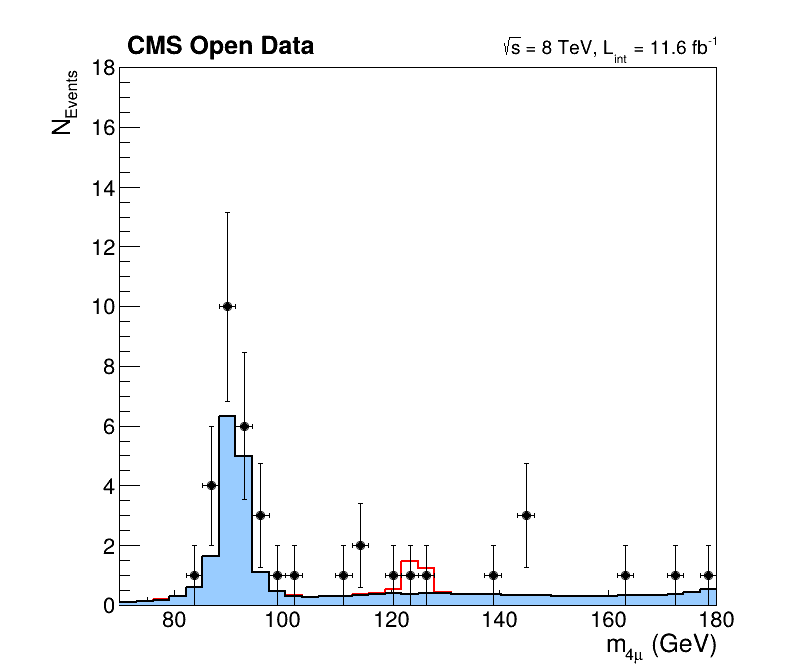

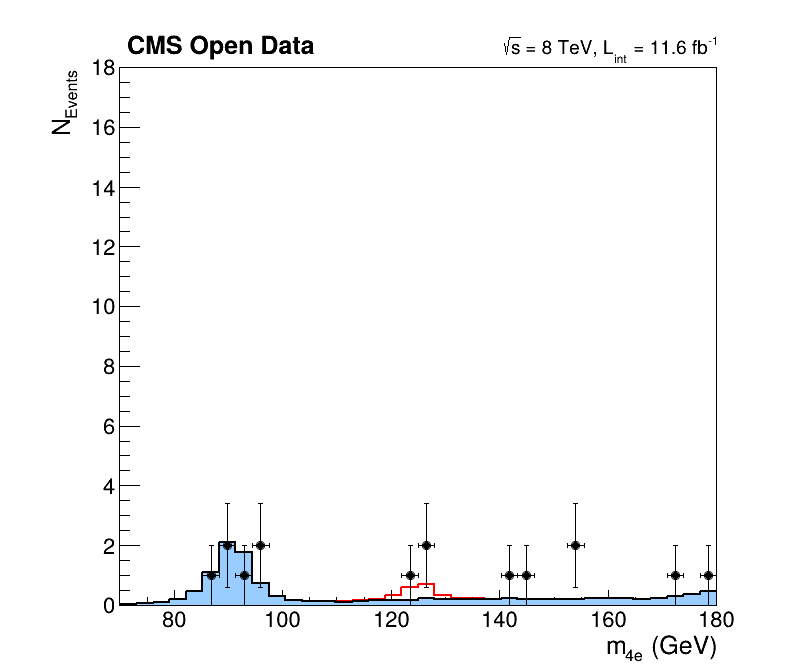

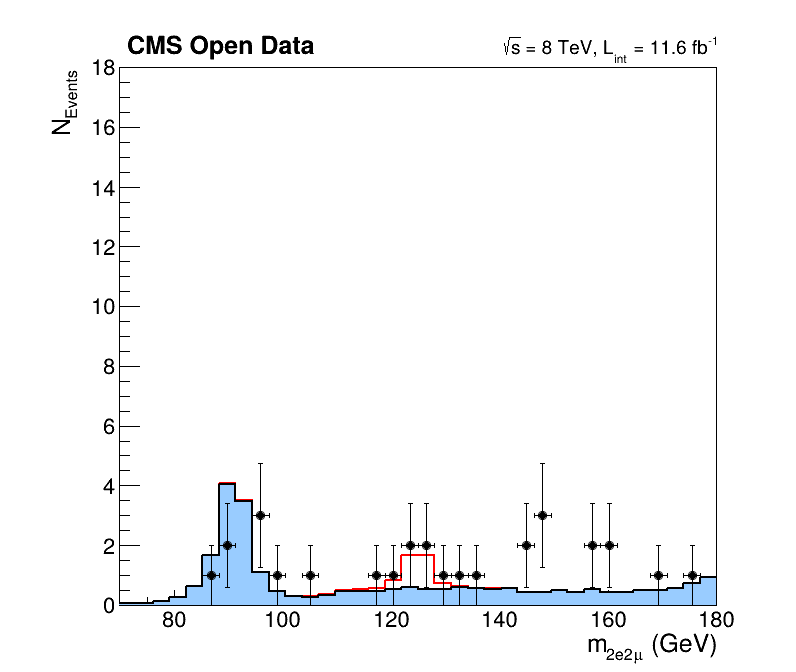

In [16]:
plot(signal_4mu, background_4mu, data_4mu, "m_{4#mu} (GeV)", "higgs_4mu.pdf")
plot(signal_4el, background_4el, data_4el, "m_{4e} (GeV)", "higgs_4el.pdf")
plot(signal_2el2mu, background_2el2mu, data_2el2mu, "m_{2e2#mu} (GeV)", "higgs_2el2mu.pdf")

Combined plots
If this was done before plotting the others, calling the `Add` function
on the `signal_4mu` histogram would modify the underlying `TH1D` object.
Thus, the histogram with the 4 muons reconstruction would be lost,
instead resulting in the same plot as the aggregated histograms.

In [17]:
h_sig_4l = signal_4mu
h_sig_4l.Add(signal_4el)
h_sig_4l.Add(signal_2el2mu)

h_bkg_4l = background_4mu
h_bkg_4l.Add(background_4el)
h_bkg_4l.Add(background_2el2mu)

h_data_4l = data_4mu
h_data_4l.Add(data_4el)
h_data_4l.Add(data_2el2mu)

True

Plot aggregated histograms

Info in <TCanvas::Print>: pdf file higgs_4l.pdf has been created


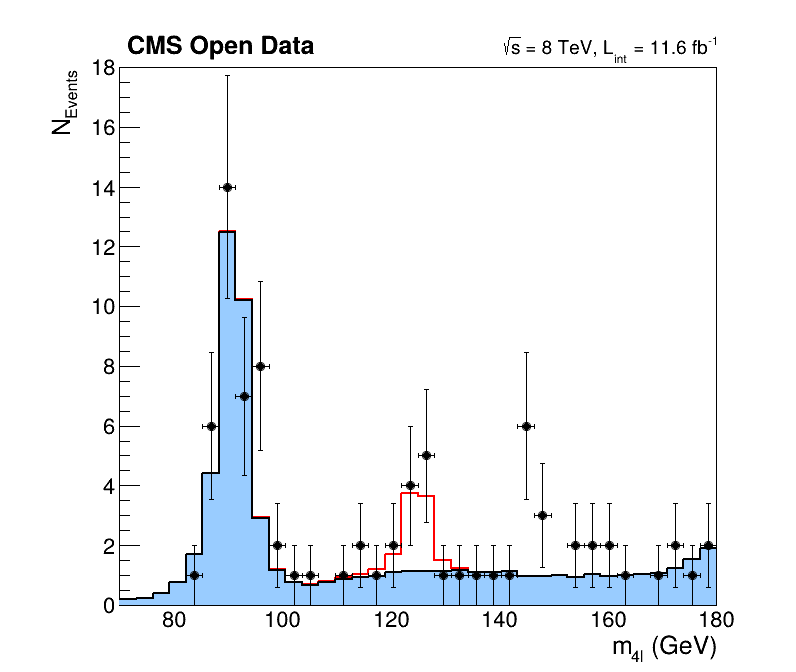

In [18]:
plot(h_sig_4l, h_bkg_4l, h_data_4l, "m_{4l} (GeV)", "higgs_4l.pdf")

Draw all canvases 

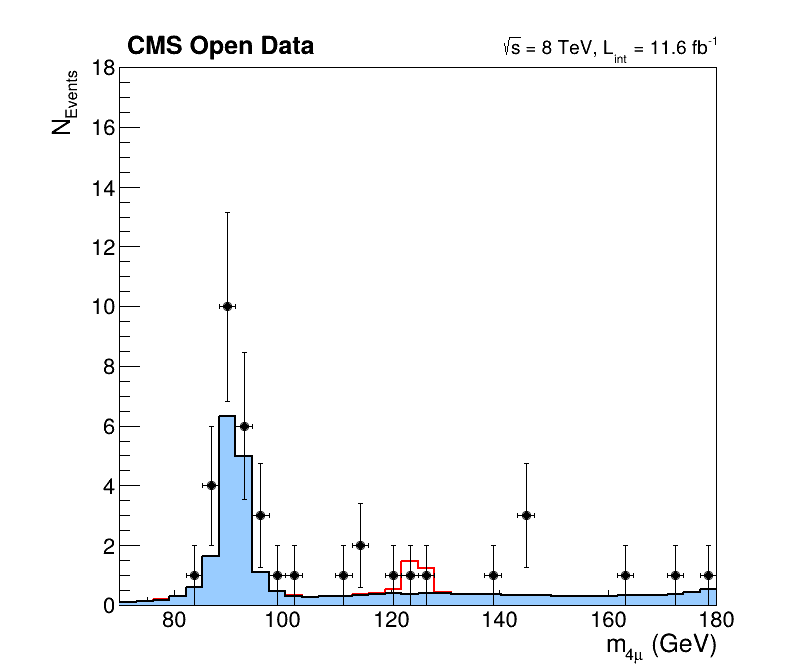

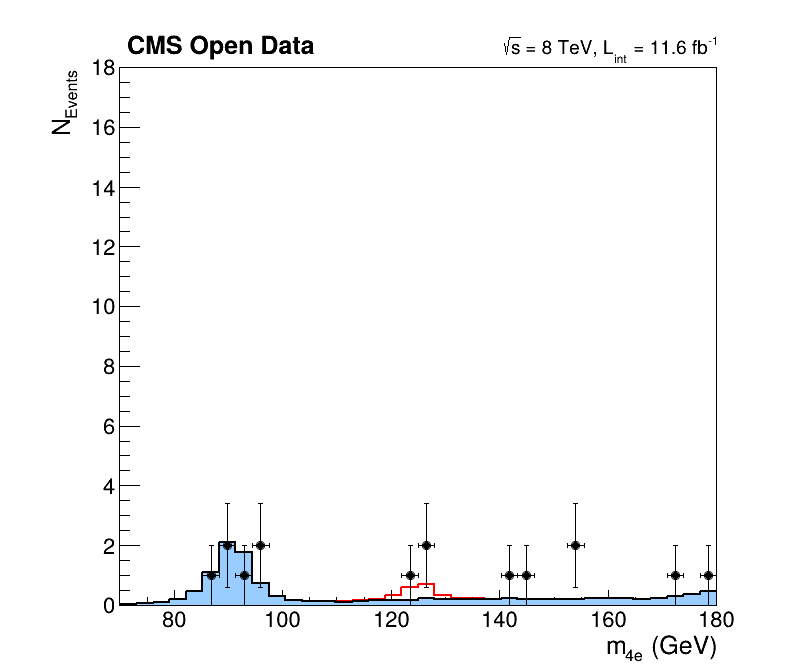

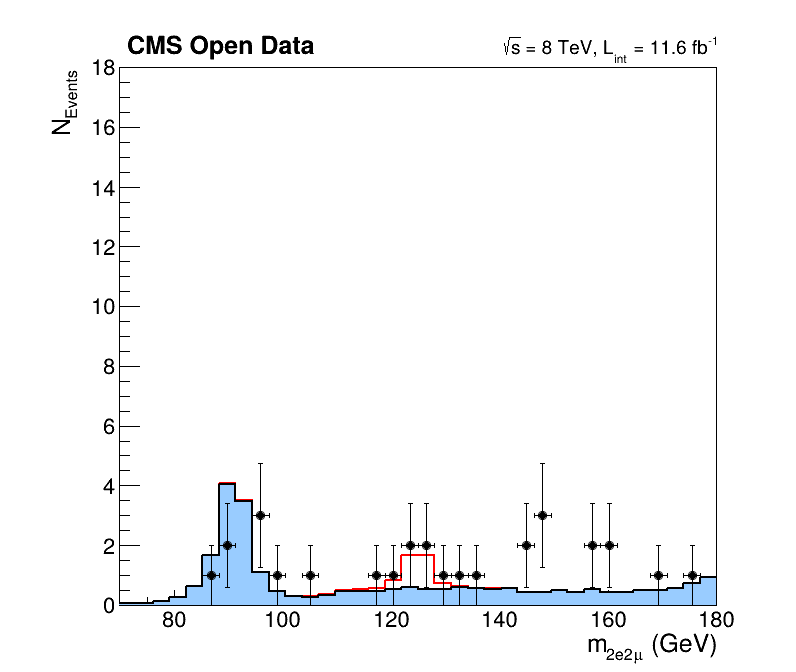

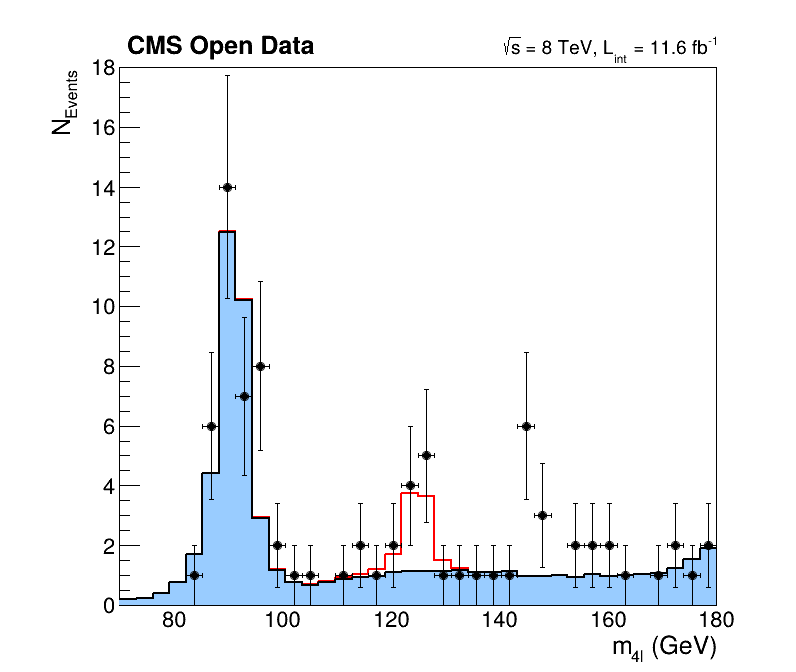

In [19]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()